In [ ]:
from river import drift
from drift_runner.utils import get_paths
from stream_generator import FeatureImportanceChangeGenerator
from drift_runner.drift_runner import DriftDetectionRunner
import warnings
warnings.filterwarnings('ignore')


## loop

In [ ]:
drift_detectors = {
    'adwin': drift.ADWIN(),
    'kswin': drift.KSWIN()
}

n_histories = [1000, 2000]
strategies = ['all_features_no_reset', 'all_features_with_reset', 'boruta_initial_only', 'boruta_dynamic', 'alpha_dynamic']
feature_selectors = ['boruta', 'alpha']

In [ ]:
seed = 160
n_features = 20
n_important_features = 5
importance_change_interval = 10

In [ ]:
for detector in drift_detectors:
    for strategy in strategies:
        feature_selector = strategy.split('_')[0]
        feature_selector = feature_selector if feature_selector in ['boruta', 'alpha'] else None
        if strategy in ['boruta_initial_only', 'boruta_dynamic', 'alpha_dynamic']:
            for n_history in n_histories:
                plot_path, export_path = get_paths(detector, seed, n_history, strategy)
                
                generator = FeatureImportanceChangeGenerator(n_features=n_features, n_important_features=n_important_features, importance_change_interval=importance_change_interval, random_seed=seed)
                runner = DriftDetectionRunner(generator, drift_detectors[detector], feature_selector, n_history=n_history, plot_path=plot_path, export_path=export_path, print_plot=False)
                runner.run(mode=strategy)
        else:
            n_history = 1
            plot_path, export_path = get_paths(detector, seed, n_history, strategy)
            
            generator = FeatureImportanceChangeGenerator(n_features=n_features, n_important_features=n_important_features, importance_change_interval=importance_change_interval, random_seed=seed)
            runner = DriftDetectionRunner(generator, drift_detectors[detector], feature_selector, n_history=n_history, plot_path=plot_path, export_path=export_path, print_plot=False)
            runner.run(mode=strategy)
                

## single

In [ ]:
strategy = 'alpha_dynamic'
n_history = 2000
seed = 160
feature_selector = 'alpha'
chosen_detector = 'adwin'

generator = FeatureImportanceChangeGenerator(n_features=20, n_important_features=5, importance_change_interval=10, random_seed=seed)

plot_path, export_path = get_paths(chosen_detector, seed, n_history, strategy)



runner = DriftDetectionRunner(generator, drift.ADWIN(), feature_selector, n_history=2000, plot_path=plot_path, export_path=export_path)
runner.run(mode=strategy)

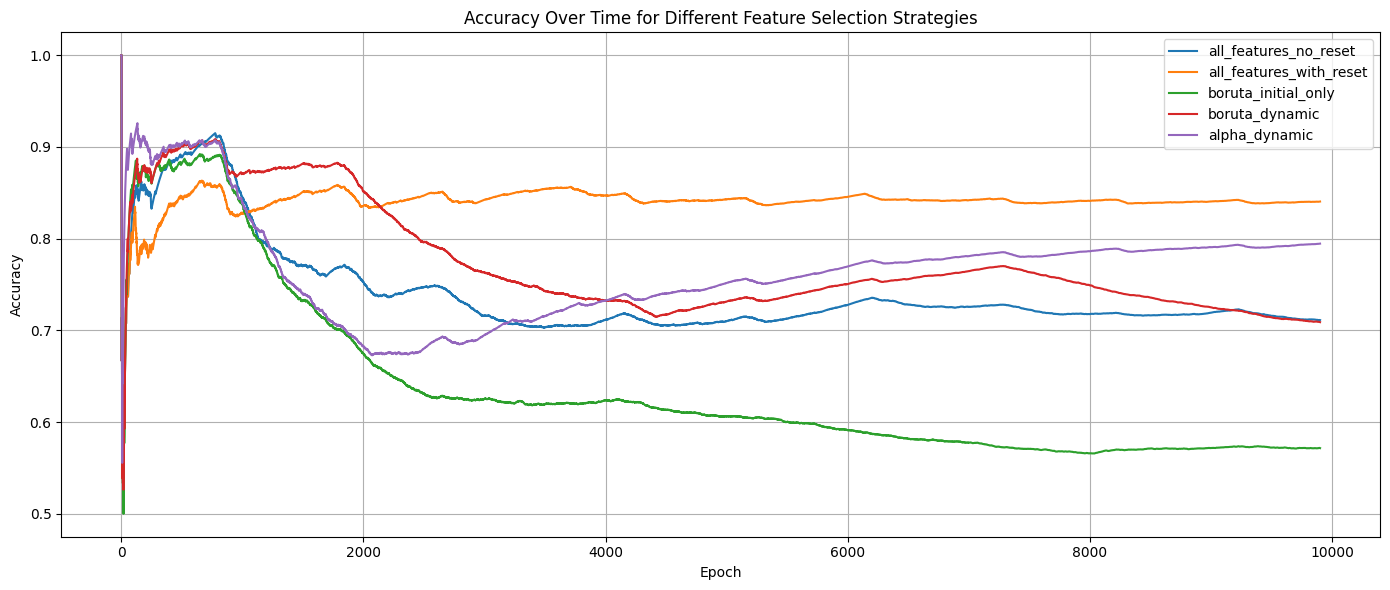

In [10]:
import os
import json
import matplotlib.pyplot as plt

strategies = [
    'all_features_no_reset',
    'all_features_with_reset',
    'boruta_initial_only',
    'boruta_dynamic',
    'alpha_dynamic'
]

plt.figure(figsize=(14, 6))

for strategy in strategies:
    # Choose path based on strategy type
    if strategy in ['boruta_initial_only', 'boruta_dynamic', 'alpha_dynamic']:
        path = f"logs/adwin/160_seed/2000_window/{strategy}.json"
    else:
        path = f"logs/adwin/160_seed/{strategy}.json"

    with open(path, "r") as f:
        data = json.load(f)

    # Extract epochs and accuracies
    epochs = data["results"]["epochs"]
    accuracies = data["results"]["accuracies"]

    # Plot the accuracy curve
    plt.plot(epochs, accuracies, label=strategy)

# Labels and legend
plt.title("Accuracy Over Time for Different Feature Selection Strategies")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
